**Classification By gender**

Dans cette partie, nous allons s'intéresser à la prédiction de sexe de la personne à partir des Deep features calculées par le modèle FaceNet pré-entrainé. 
Dans un premier instant, on va essayer de voir les performances d'un classifier simple : par exemple un SVM et ensuite trouver des méthodes qui permettent d'améliorer la précision de la prédiction du genre du personne.

In [1]:
# importation des bibliotheques
import numpy as np   
import pandas as pd   
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

from time import time

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [16]:
# describition du tableau
df = pd.read_csv("age_gender.csv")
df['pixels'] = df.apply(lambda row:   list(map(int, row['pixels'].split(' '))) , axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [18]:
### charger les matrices de données (Deep features) : X et label : y
X = np.vstack(df['pixels'].values)
#X = pd.read_csv('features.csv', sep=',')
#X = np.load('features.npz')["X"]
eth = df.ethnicity.values
y = df.gender.values
del df # supprimer le Dataframe du fichier csv

In [19]:
name_gender = ['Male', 'Female']

In [20]:
# affichage les dimensions des matrices de X et y
print("taille de X :", X.shape)
print("taille de y :", y.shape)

taille de X : (23705, 2304)
taille de y : (23705,)


In [22]:
print("taille de X :", X[eth==1].shape)
print("taille de y :", y[eth==1].shape)

taille de X : (4526, 2304)
taille de y : (4526,)


In [7]:
normalised = False
if normalised:
    X = X / 225

In [64]:
# preparation des deux ensembles de train (67%) et de test (33%)
eth_ind = 4
X_train, X_test, y_train, y_test = train_test_split( X[eth==eth_ind], y[eth==eth_ind], test_size=0.333,
                                                    random_state=42, stratify = y[eth==eth_ind])

les métriques utilisées pour l'évaluation des performances du modèles sont : 
- la sensibilité ou [précision](https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel) 
- la spécificité ou [recall](https://en.wikipedia.org/wiki/Precision_and_recall#Recall)
- l'accuracy
- AUC (Aera Under Curve)

In [65]:
def sensibility(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1] 
    fn = cm[1, 0] 
    tp = cm[1, 1]

    return tp/(tp+fn)

def specificity(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1] 
    fn = cm[1, 0] 
    tp = cm[1, 1]

    return tn/(tn+fp)

**evaluation des performances**

In [66]:
#clf = SVC(C= 1000, gamma = 0.1, kernel='rbf', class_weight='balanced')
clf = KNeighborsClassifier(n_neighbors=15)

In [67]:
t0 = time()
clf.fit(X_train, y_train)
print(">> Train : done in %dmin %ds" % ((time() - t0)//60 ,(time() - t0)%60  ))

t0 = time()
y_pred = clf.predict(X_test)
print(">> Test  : done in %dmin %ds" % ((time() - t0)//60 ,(time() - t0)%60  ))

>> Train : done in 0min 0s
>> Test  : done in 0min 0s


              precision    recall  f1-score   support

           0       0.71      0.69      0.70       253
           1       0.76      0.77      0.77       311

    accuracy                           0.74       564
   macro avg       0.73      0.73      0.73       564
weighted avg       0.74      0.74      0.74       564



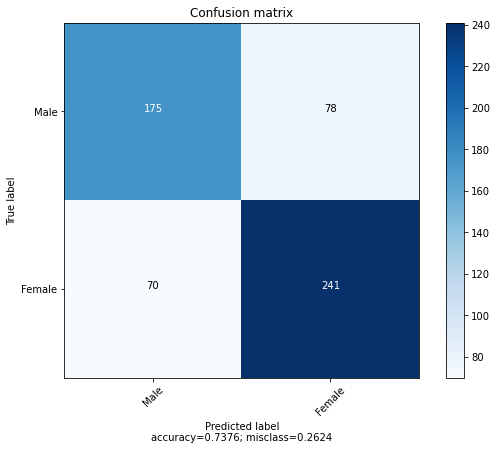

In [68]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,name_gender,title='Confusion matrix')
#sns.heatmap(cm, annot=True, fmt='d')

**Visualisation des images malclassifiées**

In [69]:
import random
import cv2

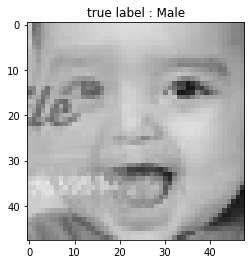

In [75]:
idx = np.where(y_test != y_pred)[0]
i = random.randint(0,len(idx))

n = 48

img = X_test[i]
img = img.reshape(n, -1)
#x = cv2.resize(img, dsize=(140, 140), interpolation=cv2.INTER_CUBIC)
x = img.reshape(1,img.shape[0],img.shape[1],1)
img_3C = np.repeat(x, 3, -1)[0]

# plotting the image
plt.title("true label : "+name_gender[y_test[i]])
plt.imshow(img_3C, interpolation='nearest')

**Optimisation des performances : Grid search**

Ensuite, on va evaluer les performances du modèle sans faire un grid search vu que pour 2 Validation croisées ça prend plus de 18min 18s d'apprentissage. 

In [71]:
passez = 'Non'
assert passez != 'Non', 'We should stop here !'

AssertionError: We should stop here !

In [ ]:
#Knearest neighbors 
print("Fitting the classifier to the training set")
t0 = time()

param_grid = {'n_neighbors': [2,3,4,5,6,7,8,9,10]}

scoring = {'AUC': 'roc_auc', 'score': 'accuracy',
           'sensib' : sensibility, 'spec' : specificity}

clf = GridSearchCV(
    KNeighborsClassifier(), param_grid,
    cv=3, scoring=scoring, refit='AUC', return_train_score=True
)
clf = clf.fit(X_train, y_train)


print("done in %dmin %ds" % ((time() - t0)//60 ,(time() - t0)%60  ))

print("Best estimator found by grid search:")
print(clf.best_estimator_)

les résultats : l'accuracy est de 70%, un score pas très motivant ! 

In [ ]:
t0 = time()
y_pred = clf.predict(X_test)
print("done in %dmin %ds" % ((time() - t0)//60 ,(time() - t0)%60  ))

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=range(2))

sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
clf.scoring